# Minimal PCV example: single Poisson model (fully online inference)

In this example we estimate the predictive density for a simple Poisson regression using leave-one-out cross-validation. There is no model selection, we are simply measuring predictive ability.

Of course, this problem does not require parallel sampling. However, it is a very simple model where it makes sense to use CV, so we use it to demonstrate the method.

This standalone notebook depends only on JAX, Blackjax, and matplotlib.

## PCV implementation

In [17]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import blackjax as bj
import matplotlib.pyplot as plt

Parallel sampler for PCV.

In [18]:
def pcv_LogS_sampler_online(key, log_dens_fn, log_pred_fn, init_pos, C_k, L, H, G, D, kparam):
    """Sampler for parallel cross-validation using LogS for a single model.
    
    Generates the statistics required to estimate ESS, MCSE, Rhat_max, and
    the Rhat_max benchmark. Space complexity is O(K*L*D), independent of
    G and H and therefore constant with respect to MCMC chain length.

    Args:
        key: JAX PRNG key array
        log_dens_fn: log density function with signature (params, fold_id)
        log_pred_fn: log predictive density function with signature (params, fold_id)
        init_pos: K*L*p pytree of initial positions for each fold and chain
        C_k: K-array of centering constants per fold
        L: number of chains
        H: MCMC draws per batch
        G: number of batches per block
        D: number of shuffle blocks
        kparam: dictionary of hyperparameters for Blackjax HMC kernel
    
    Returns:
        Tuple: (last_state, Ux, Ux2, Vx, Vx2, Yx, Yx2, E)
    """
    K = C_k.shape[0]

    def run_chain(init_pos, chain_key, fold_id, C):  # sample from a single chain
        fold_log_dens_fn = lambda params: log_dens_fn(params, fold_id)
        hmc_kernel = bj.hmc(fold_log_dens_fn, **kparam)

        def mcmc_step(carry_state, _): # a single mcmc step
            key, prev_state, Zx, Ux2, E, Yx, Yx2 = carry_state
            step_key, carry_key = jax.random.split(key)
            state, info = hmc_kernel.step(step_key, prev_state)  # one mcmc step
            lpred = log_pred_fn(state.position, fold_id)  # cond. log predictive
            E = E + info.is_divergent
            Zx = jnp.logaddexp(Zx, lpred)  # increment accumulators
            Ux2 = jnp.logaddexp(Ux2, 2*lpred)
            Yx += lpred - C
            Yx2 += (lpred - C)**2
            return (carry_key, state, Zx, Ux2, E, Yx, Yx2), None

        def batch_step(batch_carry, _): # one batch of H mcmc steps
            key, init_state, Ux, Ux2, Vx, Vx2, E, Yx, Yx2 = batch_carry
            init_carry = (key, init_state, -jnp.inf, Ux2, E, Yx, Yx2)
            (carry_key, state, Zx, Ux2, E, Yx, Yx2), _ = \
                jax.lax.scan(mcmc_step, init_carry, None, length=H)
            Zx_bar = Zx - jnp.log(H)  # this batch mean
            Vx = jnp.logaddexp(Vx, Zx_bar)  # increment accumulators
            Vx2 = jnp.logaddexp(Vx2, 2*Zx_bar)
            Ux = jnp.logaddexp(Ux, Zx)
            return (carry_key, state, Ux, Ux2, Vx, Vx2, E, Yx, Yx2), None

        def block_step(block_carry, _): # one block of G batches
            init_carry = block_carry + (0, 0,)  # zeros are (Yx, Yx2)
            (key, prev_state, Ux, Ux2, Vx, Vx2, E, Yx, Yx2), _ = \
                jax.lax.scan(batch_step, init_carry, None, length=G)
            return (key, prev_state, Ux, Ux2, Vx, Vx2, E), (Yx, Yx2)

        init_state = hmc_kernel.init(init_pos)
        init_carry = (chain_key, init_state, -jnp.inf, -jnp.inf, -jnp.inf, -jnp.inf,  0)
        #                                        (Ux),    (Ux2),     (Vx),    (Vx2), (E)
        return jax.lax.scan(block_step, init_carry, None, length=D)

    def run_fold(fold_key, ch_init_pos, fold_id, C): # run L chains for one fold
        sampling_fn = jax.vmap(lambda pos, key: run_chain(pos, key, fold_id, C))
        return sampling_fn(ch_init_pos, jax.random.split(fold_key, L))

    (_, last_state, Ux, Ux2, Vx, Vx2, E), (Yx, Yx2) = \
        jax.vmap(run_fold)(jax.random.split(key, K), init_pos, jnp.arange(K), C_k)
    return (last_state, Ux, Ux2, Vx, Vx2, Yx, Yx2, E)

Helper function for computing the (log of the) variance from welford statistics. We use logs to numerically stabilize calculations.

In [19]:
def log_var(n, log_sum_X, log_sum_X2):  # log variance from welford states
    return (-jnp.log(n - 1) + log_sum_X2 
        + jnp.log1p(-jnp.exp(2 * log_sum_X - jnp.log(n) - log_sum_X2)))

Function to compute $\widehat{R}$ from welford statistics.

In [20]:
def online_rhats(Yx_kl, Yx2_kl, N):
    """Compute rhat statistics per chain using welford statistics
    
    Args:
        Yx_kl: K*L array of centered sum of log predictive densities per chain
        Yx2_kl: K*L array of sum of centered squared log predictive densities per chain
        N: number of samples per chain
    
    Returns:
        K-vector of rhat statistics
    """
    assert Yx_kl.shape == Yx2_kl.shape
    W = ((Yx2_kl - N*(Yx_kl/N)**2)/(N-1)).mean(axis=1)
    B = N*(Yx_kl/N).var(axis=1, ddof=1)
    V = W*(N-1)/N + B/N
    return jnp.sqrt(V/W)

Function to compute shuffled $\widehat{R}_{max}$ draws, i.e. the benchmark.

In [21]:
def shuffled_rhat_maxs(key, Yx, Yx2, N, num_shuffles):
    """Simulate Rhat_max for synthetic mixed chains by shuffling blocks
    
    Args:
        key: jax.random.PRNGKey
        Ux: K*L*D array of log sum of predictive densities per fold, chain, and block
        Ux2: K*L*D array of log sum of square predictive densities per fold, chain, and block
        N: number of samples per chain
        num_shuffles: number of shuffles to draw
    """
    K, L, D = Yx.shape
    assert Yx.shape == Yx2.shape
    def shuffle_welford_stats(block_lS, shuff_key):
        def shuffle_chains(shuff_key, k, s):
            return jax.random.choice(shuff_key, block_lS[k, :, s], shape=(L,))
        def shuffle_fold(shuff_key, k):
            keys = jax.random.split(shuff_key, D)
            shuffled = jax.vmap(shuffle_chains, in_axes=(0,None,0))(keys, k, jnp.arange(D))
            return shuffled.sum(axis=0)  # stats for synthetic chains
        return jax.vmap(shuffle_fold)(jax.random.split(shuff_key, K), jnp.arange(K))
    def draw(draw_key):
        # note common keys so shuffling generates same order for both stats
        sUx = shuffle_welford_stats(Yx, draw_key)
        sUx2 = shuffle_welford_stats(Yx2, draw_key)
        return online_rhats(sUx, sUx2, N).max()
    return jax.vmap(draw)(jax.random.split(key, num_shuffles))

All-in-one function to do initial adaptation, full-data sampling, parallel warmup, parallel sampling, then compute statistics.

In [22]:
def basic_pcv_LogS(key, log_dens_fn, log_pred_fn, init_pos, K, L, H, G, D, N_delta, N_fd):
    """
    Basic parallel cross-validation using LogS and Hamiltonian Monte Carlo (HMC)

    This variant performs full-data sampling, parallel warmup, parallel sampling,
    and computes summaries, all in one function.

    Args:
        key: JAX PRNG key array
        log_dens_fn: log density function with signature (params, fold_id)
        log_pred_fn: log predictive density function with signature (params, fold_id)
        init_pos: initial position for a single chain
        K: number of folds
        L: number of chains
        H: MCMC draws per batch
        G: number of batches per block
        D: number of shuffle blocks
        N_delta: number of samples for estimating CV se
        N_fd: Number of samples for full-data posterior
    """
    N = G*D*H  # number of samples per chain

    warmup_k1, warmup_k2, warmup_k3, warmup_k4, sampling_key, shuff_key = jax.random.split(key, 6)

    # Stan-style window adaptation HMC warmup
    full_data_dens = lambda x: log_dens_fn(x, -1)
    res, _ = (bj
                 .window_adaptation(bj.hmc, full_data_dens, num_integration_steps=5)
                 .run(warmup_k1, init_pos))
    kparam = res.parameters

    # Draw initial samples from full-data posterior - for simplicity use a single chain
    fd_kernel = bj.hmc(full_data_dens, **kparam)
    def inference_loop(params, key):
        params, _ = fd_kernel.step(key, params)
        return params, params.position
    sampling_keys = jax.random.split(warmup_k2, N_fd)
    _, init_pos = jax.lax.scan(inference_loop, res.state, sampling_keys)

    initial_idxs = jax.random.choice(warmup_k3, jnp.arange(init_pos.shape[0]), shape=(K,L,))
    ch_init_pos = init_pos[initial_idxs, :]

    sample = jax.jit(lambda key, pos, C_k: pcv_LogS_sampler_online(key, log_dens_fn, log_pred_fn, pos, C_k, L, H, G, D, kparam))
    warm_states, _, _, _, _, Yx_wu, _, _ = sample(warmup_k4, ch_init_pos, jnp.zeros(K))  # parallel warmup
    C_k = Yx_wu.sum(axis=(1,2))/(L*N)  # sum over chains and blocks
    _, Ux, Ux2, Vx, Vx2, Yx, Yx2, E = sample(sampling_key, warm_states.position, C_k)  # parallel sampling

    # sum over blocks to get chain-level statistics
    Yx_k = Yx.sum(axis=2)
    Yx2_k = Yx2.sum(axis=2)

    # effective sample size (ess)
    log_ssq_k = log_var(L*N, logsumexp(Ux, axis=1), logsumexp(Ux2, axis=1))
    log_sigsq_k = jnp.log(H) + log_var(L*N//H, logsumexp(Vx, axis=1), logsumexp(Vx2, axis=1))
    ess = N * L * jnp.exp(logsumexp(log_ssq_k) - logsumexp(log_sigsq_k))

    # Expected log predictive density (elpd)
    log_phat_k = logsumexp(Ux, axis=1) - jnp.log(L*N)
    elpd = log_phat_k.sum()

    # Monte Carlo standard error (mcse)
    log_var_phat_k = log_ssq_k - jnp.log(L*N)  # log variance of mean density
    log_var_etahat_k = log_var_phat_k - 2*log_phat_k  # log var of log mean density (delta method)
    elpd_mcse = jnp.exp(0.5*logsumexp(log_var_etahat_k))  # sum of independent variances

    # CV standard error (cvse) by simulation with (truncated) normal mean density assumption
    log_scale_coef_k = jnp.expand_dims(-0.5 * log_var_phat_k, axis=1)
    sim_mean_k = jnp.exp(jnp.expand_dims(log_phat_k, axis=1) + log_scale_coef_k)
    scaled_draw_k_i = sim_mean_k + jax.random.truncated_normal(key=key, lower=-sim_mean_k, upper=jnp.inf, shape=(K, N_delta))
    draw_cvvar_i = jnp.var(jnp.log(scaled_draw_k_i) - log_scale_coef_k, axis=0)  # cv var draws
    cvse = jnp.sqrt(jnp.mean(draw_cvvar_i))

    # Rhat_max mixing statistic and benchmark
    rhat_max = online_rhats(Yx_k, Yx2_k, N).max()
    shuff_rhat_maxs = shuffled_rhat_maxs(shuff_key, Yx, Yx2, N, 500)
    q_rhat_max = jnp.mean(rhat_max >= shuff_rhat_maxs)

    print(f"{K} folds generated {L*N} draws each ({L} chains * {N} iter, {L*N//H} batches of {H})")
    print(f"elpdhat: {elpd:.4f} (mcse {elpd_mcse:.4f}, CV se {cvse:.4f})")
    print(f"overall ess: {ess:.0f}")
    print(f"rhat_max: {rhat_max:.4f} (q = {q_rhat_max*100:.0f}%)")

    fig, ax = plt.subplots(figsize=(6,2.5))
    ax.hist(shuff_rhat_maxs[jnp.isfinite(shuff_rhat_maxs)], bins=20)
    ax.axvline(rhat_max, color='red')
    ax.ticklabel_format(useOffset=False)
    ax.set_title(r'$\widehat{R}_{max}$ and emulated mixed benchmark')
    fig.tight_layout()


## Model definition and inference

The model is
$$ y_i | x_i, \beta \sim \mathrm{pois}\left(\exp\left(x_i^\top\beta\right)\right), \qquad i=1,\dots,N, $$
and we impose a spherical normal prior, $ \beta_j \sim \mathcal{N}\left(0,1\right),\ j=1,\dots,p $.

In [23]:
jax.config.update("jax_enable_x64", True)  # use double precision

# generate data for poisson regression model
data_key = jax.random.PRNGKey(seed=42) # data seed
p = 5  # regressors including the constant
n_obs = 50  # number of observations
beta_true = jnp.array([1., 1., 1., 0., 0.])
data_k1, data_k2 = jax.random.split(data_key)
X = jnp.hstack([
    jnp.ones((n_obs,1)),
    jax.random.normal(key=data_k1, shape=(n_obs, p-1))])
y = jax.random.poisson(key=data_k2, lam=jnp.exp(X @ beta_true))

# log density function, by fold
def log_dens_fn(params, fold_id):
    mask = jnp.arange(n_obs) != fold_id  # LOO-CV, use -1 for full data
    return (jax.scipy.stats.poisson.logpmf(y, jnp.exp(X @ params)) * mask).sum()

# conditional predictive function, by fold
def log_pred_fn(params, fold_id):
    return jax.scipy.stats.poisson.logpmf(y[fold_id], jnp.exp(X[fold_id] @ params))


Now perform parallel cross-validation to estimate predictive ability under LogS

50 folds generated 4000 draws each (4 chains * 1000 iter, 80 batches of 50)
elpdhat: -87.8131 (mcse 0.0316, CV se 0.9501)
overall ess: 2796
rhat_max: 1.0020 (q = 77%)


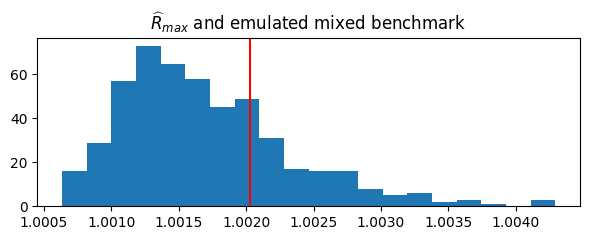

In [24]:
basic_pcv_LogS(
    key= jax.random.PRNGKey(seed=123),  # inference seed
    log_dens_fn=log_dens_fn,  # log density function, by fold
    log_pred_fn=log_pred_fn,  # conditional predictive function, by fold
    init_pos=jnp.zeros(p),  # initial mcmc warmup position
    K=n_obs,  # number of folds (LOO-CV)
    L=4,  # number of chains
    H=50,  # batch size
    G=5,  # batches per shuffle block
    D=4,  # shuffle blocks
    N_delta=500,  # CV se estimation draws
    N_fd=500  # full-data mcmc draws
)